In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pylab
from pylab import rcParams
rcParams['figure.figsize'] = 10, 7
import astroML 
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=14, usetex=True)

In [48]:
# this functions may be for johnson instead of stromgren
def Teff(bv):
    return 7540./(bv+0.865)
def L(V,d):
    return (V-5*np.log10(d/10)-4.83)/2.5

In [49]:
stars = np.loadtxt('isochrone/stars_std.lst')
stars_Teff_L = np.empty((np.shape(stars)[0],2)) # Teff and luminosity from V and b-v 
#extrapolated using a formula in Mariona's notes. It contains Teff,L 
# in the second dimension
stars_Teff_L[:,0] = Teff(stars[:,2])
d=830
stars_Teff_L[:,1] = -L(stars[:,0],d)

iso1 = np.loadtxt('isochrone/iso_4p2Gyr_z0_d1Kpc_r0p03.dat')
iso2 = np.loadtxt('isochrone/iso_4p2Gyr_z0_d830pc_r0p03.dat')
iso3 = np.loadtxt('isochrone/iso_4p4Gyr_z0_d830pc_r0p03.dat')
iso4 = np.loadtxt('isochrone/iso_a4000Myr_z0p01_d850pc_r0p04.dat')
iso5 = np.loadtxt('isochrone/iso_a5000Myr_z0p02_d1Mpc_r0')

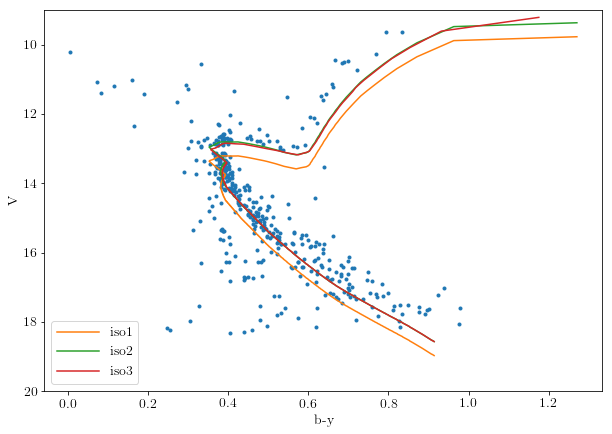

In [129]:
plt.plot(stars[:,2], stars[:,0],'.') #x-axis: b-y; y-axis: V
plt.plot(iso1[:,1], iso1[:,0], '-', label='iso1')
plt.plot(iso2[:,1], iso2[:,0], '-', label='iso2')
plt.plot(iso3[:,1], iso3[:,0], '-', label='iso3')
#plt.plot(10**iso4[:,3], iso4[:,2], '-', label='iso4')
#plt.plot(10**iso5[:,3], iso5[:,2], '-', label='iso5')
plt.ylim([20, 9])
#plt.xlim([10000, 3000])
plt.xlabel('b-y')
plt.ylabel('V')
plt.legend()

Text(0,0.5,u'$L/L_\\odot$')

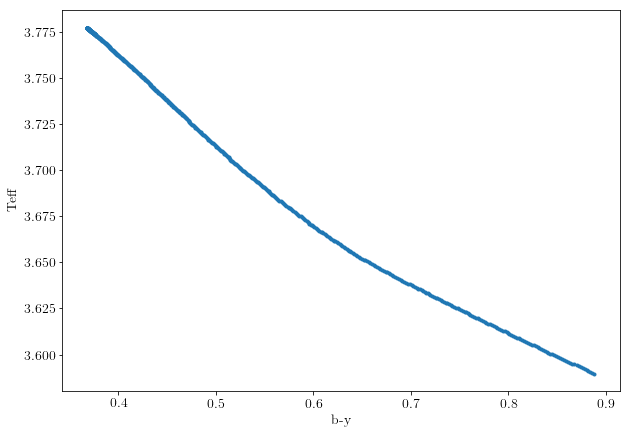

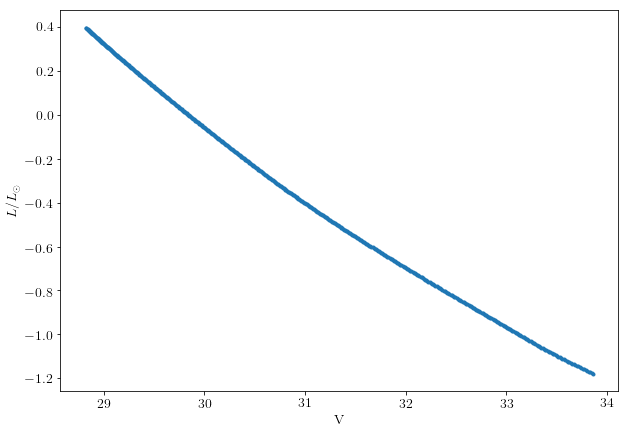

In [85]:
# la interpolació s'ha de fer només per la main sequence, 
# per tant cal tallar al màxim per eliminar la relacio bv Teff 
# post MS, per gegants i en proces de se-ho, la funció és bastant 
# maca
from scipy.signal import argrelextrema
#sorted_index = np.argsort(iso5[:Tmax,0])
#sorted_by = iso5[sorted_index,1]
maxInd = argrelextrema(iso5[:,3], np.less)[0][0]
by = iso5[:maxInd,1]
Teff = iso5[:maxInd,3]
# els vaors de la isocrona amb index menor a maxInd son aquells 
# que pertanyen a la main sequence, per tant al fer el fit/interpolacio
# només hem de tenir en compte els vectors de 0:maxInd
plt.figure()
plt.plot(by,Teff,'.')
plt.xlabel('b-y')
plt.ylabel('Teff')
plt.figure()
plt.plot(iso5[:maxInd,0],iso5[:maxInd,2],'.') 
plt.xlabel('V')
plt.ylabel('$L/L_\odot$')

[3.9080062500000001, -0.35937500000000033, 0.1]
[ 4.0277343  -0.80979224  0.35974768]


Text(0,0.5,u'Teff')

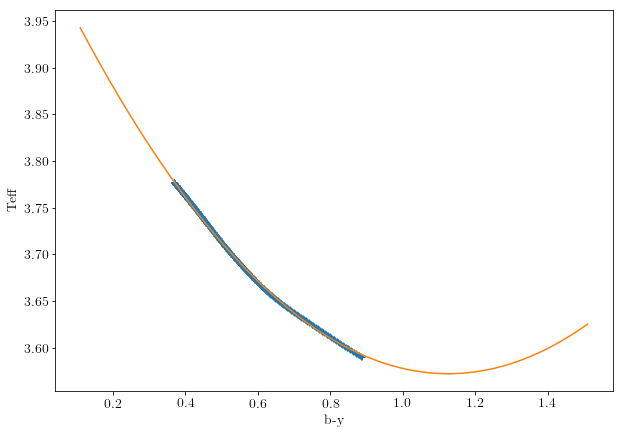

In [120]:
# fem el fit en questió. aixo no ho he borrat perque va be per 
# veure com es comporten les funcions fora de la zona MS.
# així, com més lineal és menys modifica sense sentit els resultats
# de les estrelles fora de la MS.
def curvefitter(x,p0,p1,p2):
    # params has dimension 5 (from 0 to 4)
    #y = p0+p1*x+p2*x**2+p3*x**3+p_1/x
    y = p0+p1*x+p2*x**2
    return y 
p1_0 = (Teff[-1]-Teff[0])/(by[-1]-by[0]) #first guess of params[1]
p0_0 = Teff[0]-p1_0*by[1]
p0 = [p0_0,p1_0,.1]
print p0
import scipy.optimize as opt
popt, pcov = opt.curve_fit(curvefitter,by,Teff,p0)
plt.figure()
plt.plot(by,Teff,'+')
by_grid = np.linspace(.3*min(by),1.7*max(by),1000)
plt.plot(by_grid,curvefitter(by_grid,*popt),'-')
print popt
plt.xlabel('b-y')
plt.ylabel('Teff')

In [123]:
def Vby2LT(stars,iso):
    # 1- get indMax
    maxInd = argrelextrema(iso[:,3], np.less)[0][0]
    by = iso[:maxInd,1]
    T  = iso[:maxInd,3]
    V  = iso[:maxInd,0]
    L  = iso[:maxInd,2]
    # 2- fit the curves
    # 2.1- fit T(by)
    p1_0 = (T[-1]-T[0])/(by[-1]-by[0]) #first guess of params[1]
    p0_0 = T[0]-p1_0*by[1]
    p0 = [p0_0,p1_0,.1]
    poptT, pcov = opt.curve_fit(curvefitter,by,T,p0)
    # 2.1- fit T(by)
    p1_0 = (L[-1]-L[0])/(V[-1]-V[0]) #first guess of params[1]
    p0_0 = L[0]-p1_0*V[1]
    p0 = [p0_0,p1_0,.1]
    poptL, pcov = opt.curve_fit(curvefitter,V,L,p0)
    # 3- apply the curve with the fitted parameters to V and by to 
    # get L and T
    Lstars = curvefitter(stars[:,0],*poptL)
    Tstars = curvefitter(stars[:,2],*poptT)
    return Tstars,Lstars

Text(0,0.5,u'$L/L_\\odot$')

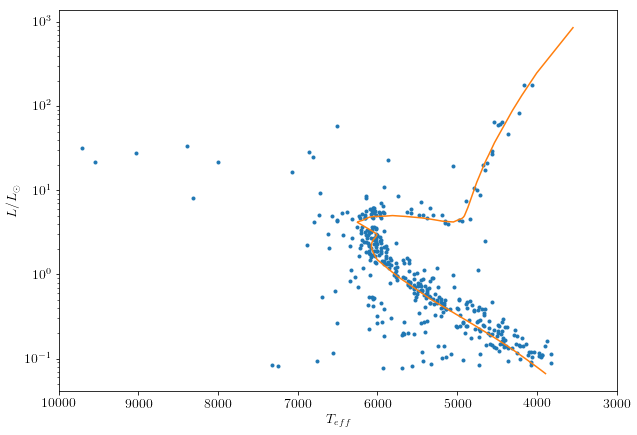

In [126]:
Tstars,Lstars = Vby2LT(stars,iso2)
plt.figure()
plt.semilogy(10**Tstars,10**Lstars,'.')
plt.semilogy(10**iso2[:,3],10**iso2[:,2],'-')
plt.xlim([10000, 3000])
plt.xlabel('$T_{eff}$')
plt.ylabel('$L/L_\odot$')